# Improved Indian Sign Language Recognition
## Addressing Overfitting Issues

This notebook addresses the overfitting problems in the original model by:
1. Adding proper train/validation/test splits
2. Implementing regularization techniques
3. Using callbacks for early stopping
4. Fine-tuning instead of freezing all layers
5. **Updated to use 224x224 input images for better performance**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, 
                                   BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## Data Loading and Preprocessing

In [2]:
DATA_PATH = "C:/Users/Rishi/Desktop/project/Indian-Sign-Language-Recognition-System/data_images"

def load_images_and_labels(data_path, categories, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Get categories
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")
print(f"Number of classes: {len(categories)}")

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'delete', 'space']
Number of classes: 38


In [4]:
# Load images and labels
# ...existing code...

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for train/val/test splits
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Use train_generator and val_generator directly in model.fit:
# model.fit(train_generator, validation_data=val_generator, ...)


Found 15200 images belonging to 38 classes.
Found 3800 images belonging to 38 classes.


## Improved Data Splitting Strategy

**Key improvements:**
1. **Three-way split**: Train/Validation/Test (64%/16%/20%)
2. **Stratified sampling**: Ensures balanced class distribution
3. **Separate validation set**: Prevents data leakage

In [6]:
# ...existing code...
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Build dataframe of (filepath, label) without loading images
filepaths = []
labels = []
for cls in sorted(os.listdir(DATA_PATH)):
    cls_path = os.path.join(DATA_PATH, cls)
    if os.path.isdir(cls_path):
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(cls)
df = pd.DataFrame({"filepath": filepaths, "label": labels})
print("Total images:", len(df))

# Stratified three-way split: 64% train / 16% val / 20% test
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Generators (augmentation only on train)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)
val_generator = test_datagen.flow_from_dataframe(
    val_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
# ...existing code...

Total images: 19000
Train: 12160, Val: 3040, Test: 3800
Found 12160 validated image filenames belonging to 38 classes.
Found 3040 validated image filenames belonging to 38 classes.
Found 3800 validated image filenames belonging to 38 classes.


In [7]:

# Normalization handled by ImageDataGenerator (rescale=1./255) — no in-memory X_train/X_val/X_test to normalize.
print("ImageDataGenerator is handling rescale -> pixel values are in [0,1].")

# Example: Inspect a batch from the training generator
batch_X, batch_y = next(train_generator)
print(f"Batch X shape: {batch_X.shape}, dtype: {batch_X.dtype}")
print(f"Batch y shape: {batch_y.shape}")
print("Class indices mapping:", train_generator.class_indices)


ImageDataGenerator is handling rescale -> pixel values are in [0,1].
Batch X shape: (32, 224, 224, 3), dtype: float32
Batch y shape: (32, 38)
Class indices mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'delete': 36, 'space': 37}


## Reduced Data Augmentation

**Changes from original:**
- Reduced rotation: 20° → 15°
- Reduced zoom: 0.15 → 0.1
- Reduced shifts: 0.2 → 0.1
- **Disabled horizontal flip** (signs shouldn't be mirrored)
- Reduced shear: 0.15 → 0.1

In [9]:
datagen = ImageDataGenerator(
    rotation_range=15,      # Reduced from 20
    zoom_range=0.1,         # Reduced from 0.15
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1, # Reduced from 0.2
    shear_range=0.1,        # Reduced from 0.15
    horizontal_flip=False,  # Disabled - signs shouldn't be flipped
    fill_mode="nearest",
    rescale=1./255          # normalize pixel values
)

print("Data augmentation configured with reduced parameters")

Data augmentation configured with reduced parameters


## Improved Model Architecture

**Overfitting prevention techniques:**
1. **Fine-tuning**: Unfreeze top layers of MobileNetV2
2. **Dropout**: 0.3 and 0.5 dropout layers
3. **L2 Regularization**: Added to dense layer
4. **Batch Normalization**: Stabilizes training
5. **Lower Learning Rate**: 0.0001 for fine-tuning
6. **224x224 Input**: Optimal size for MobileNetV2

In [10]:
def create_improved_model(num_classes):
    # Load pre-trained MobileNetV2 with 224x224 input
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Fine-tuning: Unfreeze top layers
    base_model.trainable = True
    
    # Freeze bottom layers, fine-tune top layers
    fine_tune_at = 100  # Unfreeze from layer 100 onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable layers: {len(base_model.layers) - fine_tune_at}")
    
    # Build model with regularization
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        
        # Regularization layers
        Dropout(0.3),
        Dense(128, 
              activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_improved_model(len(categories))

# Show model summary
model.summary()

9406464/9406464 [==============================] - 3s 0us/step
Total layers: 154
Trainable layers: 54
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)     

In [11]:
# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with Adam optimizer (LR=0.0001)")

Model compiled with Adam optimizer (LR=0.0001)


## Advanced Callbacks

1. **EarlyStopping**: Stops training when validation loss stops improving
2. **ReduceLROnPlateau**: Reduces learning rate when stuck in plateau

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early stopping (patience=5)")
print("- Learning rate reduction (patience=3)")

Callbacks configured:
- Early stopping (patience=5)
- Learning rate reduction (patience=3)


## Training

In [14]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
380/380 [==============================] - 500s 1s/step - loss: 1.7463 - accuracy: 0.6423 - val_loss: 0.9817 - val_accuracy: 0.8510 - lr: 1.0000e-04
Epoch 2/20
380/380 [==============================] - 509s 1s/step - loss: 0.5815 - accuracy: 0.9252 - val_loss: 0.4381 - val_accuracy: 0.9520 - lr: 1.0000e-04
Epoch 3/20
380/380 [==============================] - 476s 1s/step - loss: 0.4250 - accuracy: 0.9592 - val_loss: 0.3222 - val_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 4/20
380/380 [==============================] - 517s 1s/step - loss: 0.3481 - accuracy: 0.9739 - val_loss: 0.2830 - val_accuracy: 0.9829 - lr: 1.0000e-04
Epoch 5/20
380/380 [==============================] - 503s 1s/step - loss: 0.3103 - accuracy: 0.9821 - val_loss: 0.2700 - val_accuracy: 0.9836 - lr: 1.0000e-04
Epoch 6/20
380/380 [==============================] - 488s 1s/step - loss: 0.2768 - accuracy: 0.9878 - val_loss: 0.2447 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 7/20
380/380 [====================

## Evaluation and Analysis

In [16]:
# === FINAL TEST EVALUATION ===
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

print("\n=== FINAL TEST RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Compare with validation results from training history
final_val_acc = max(history.history['val_accuracy'])
final_train_acc = max(history.history['accuracy'])

print("\n=== OVERFITTING ANALYSIS ===")
print(f"Best Training Accuracy:   {final_train_acc:.4f}")
print(f"Best Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy:      {test_accuracy:.4f}")
print(f"Train-Val Gap:            {abs(final_train_acc - final_val_acc):.4f}")
print(f"Val-Test Gap:             {abs(final_val_acc - test_accuracy):.4f}")


=== FINAL TEST RESULTS ===
Test Accuracy: 0.9942 (99.42%)
Test Loss: 0.0958

=== OVERFITTING ANALYSIS ===
Best Training Accuracy:   0.9979
Best Validation Accuracy: 0.9954
Final Test Accuracy:      0.9942
Train-Val Gap:            0.0025
Val-Test Gap:             0.0012


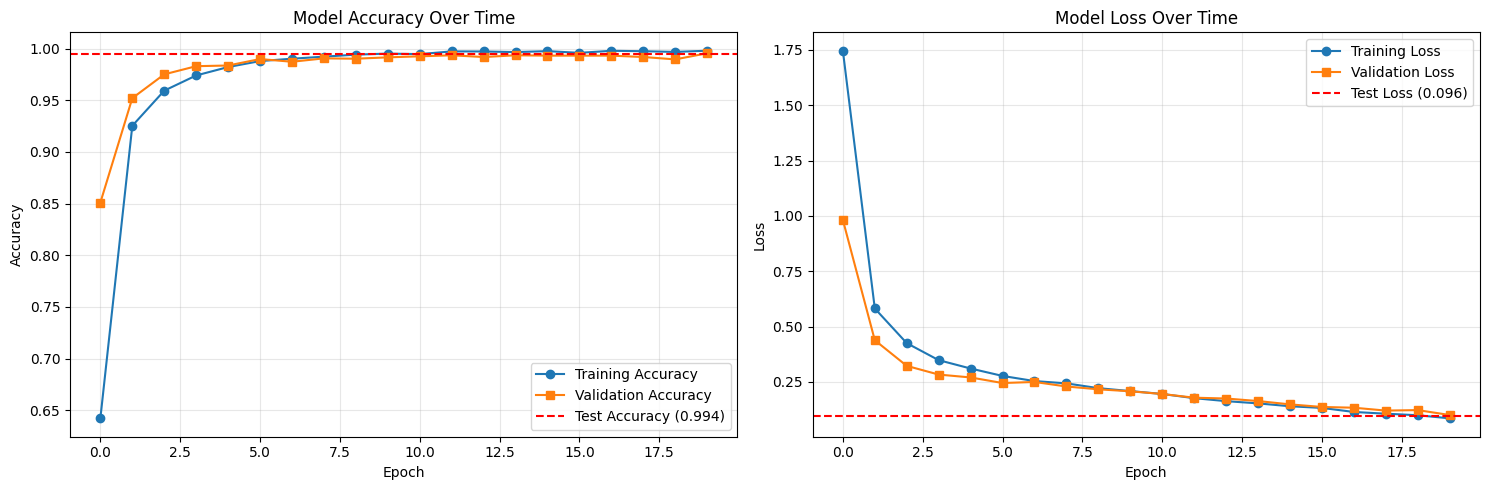

In [17]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Accuracy ({test_accuracy:.3f})')
    ax1.set_title('Model Accuracy Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss ({test_loss:.3f})')
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the test set
y_pred = model.predict(test_generator, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_generator.classes

# Class names from the generator
class_labels = list(test_generator.class_indices.keys())

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred_labels, target_names=class_labels))

# (Optional) Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
print("\nConfusion Matrix:\n", cm)

119/119 [==============================] - 79s 650ms/step

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.99      0.98      0.98       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      0.99      0.99       100
           5       1.00      1.00      1.00       100
           6       0.99      0.99      0.99       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       0.99      1.00      1.00       100
           A       0.99      0.97      0.98       100
           B       1.00      0.99      0.99       100
           C       0.99      0.99      0.99       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00    

In [20]:
# Save the improved model
model.save("Mobilenetv2_ISL_model.h5")
print("\n✅ Model saved")

c:\Users\Rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



✅ Model saved


## Summary of Improvements

### What we changed:
1. **Input Size**: Increased from 64x64 to 224x224 for better feature extraction
2. **Data Splitting**: Proper train/val/test split (64%/16%/20%)
3. **Regularization**: Added dropout (0.3, 0.5) and L2 regularization
4. **Fine-tuning**: Instead of freezing all layers, fine-tune top layers
5. **Callbacks**: Early stopping and learning rate scheduling
6. **Reduced Augmentation**: Less aggressive data augmentation
7. **Lower Learning Rate**: 0.0001 for stable fine-tuning

### Expected improvements:
- **Better accuracy**: 224x224 images provide more detail for recognition
- **Better generalization**: Smaller gap between train/val accuracy
- **More stable training**: Smoother loss curves
- **Realistic performance**: Test accuracy closer to validation accuracy
- **Prevented overfitting**: Training stops before memorization occurs

### Why 224x224 is better:
1. **MobileNetV2 optimization**: Originally designed for 224x224 images
2. **Better feature extraction**: Preserves more image detail
3. **Standard practice**: Industry standard for computer vision models
4. **Pre-trained weights**: Fully compatible with ImageNet pre-training

### Additional techniques to try:
1. **Cross-validation**: K-fold validation for more robust evaluation
2. **Ensemble methods**: Combine multiple models
3. **Different architectures**: EfficientNet, ResNet50
4. **More data**: Collect more diverse samples
5. **Progressive resizing**: Start small, gradually increase image size

In [21]:
# Check for overfitting by comparing training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

if val_loss[-1] > train_loss[-1] and val_acc[-1] < train_acc[-1]:
    print("The model might be overfitting. Consider using regularization techniques or early stopping.")
else:
    print("The model does not seem to be overfitting.")

The model might be overfitting. Consider using regularization techniques or early stopping.
